In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
plt.rcParams.update({'axes.titlesize': 'small'})
from pathlib import Path
from PIL import Image

IMG_SHAPE = (3, 64, 176)

In [4]:
import torch, torch.nn as nn
import torch.nn.functional as F

use_cuda = torch.cuda.is_available()

print("Torch version:", torch.__version__)
if use_cuda:
    print("Using GPU")
else:
    print("Not using GPU")
    
from torch.utils.data import Dataset

Torch version: 1.0.1.post2
Using GPU


In [5]:
class GlassesDataset(Dataset):
    def __init__(self, path, transform=None):
        self.data = []
        self.transform = transform
        for img_path in Path(path).iterdir():
            if img_path.suffix[1:].lower() not in ('jpg', 'png'):
                continue
                
            # this crop was chosen because glasses dimension mentioned in the paper was 64x176
            img = np.array(Image.open(str(img_path)))[52:116, 23:199, :]
            
            if self.transform is not None:
                img = self.transform(img)
            
            self.data.append(img)
        self.data = (np.array(self.data).transpose(0, 3, 1, 2) - 128.) / 128.
        
    def __getitem__(self, index):
        return self.data[index]

    def __len__(self):
        return len(self.data)

            

In [6]:
train_dataset = GlassesDataset('eyeglasses')

In [7]:
train_dataset.data.max()
# plt.imshow(train_dataset[55].transpose((1,2,0)))

0.9921875

In [8]:
def sample_noise_batch(batch_size):
    noise = torch.randn(batch_size, CODE_SIZE)
    return noise.cuda() if use_cuda else noise.cpu()
    
class Reshape(nn.Module):
    def __init__(self, shape):
        nn.Module.__init__(self)
        self.shape=shape
    def forward(self,input):
        return input.view(self.shape)

In [9]:
CODE_SIZE = 25

from itertools import count
# automatic layer name maker. Don't do this in production :)
ix = ('layer_%i'%i for i in count())

generator = nn.Sequential()

generator.add_module(next(ix), nn.Linear(CODE_SIZE, 7040))
generator.add_module(next(ix), nn.BatchNorm1d(7040))
generator.add_module(next(ix), nn.ReLU())
generator.add_module(next(ix), Reshape([-1, 160, 4, 11]))

generator.add_module(next(ix), nn.ConvTranspose2d(160, 80, 5, stride=2, padding=2, output_padding=1))
generator.add_module(next(ix), nn.BatchNorm2d(80))
generator.add_module(next(ix), nn.ReLU())

generator.add_module(next(ix), nn.ConvTranspose2d(80, 40, 5, stride=2, padding=2, output_padding=1))
generator.add_module(next(ix), nn.BatchNorm2d(40))
generator.add_module(next(ix), nn.ReLU())

generator.add_module(next(ix), nn.ConvTranspose2d(40, 20, 5, stride=2, padding=2, output_padding=1))
generator.add_module(next(ix), nn.BatchNorm2d(20))
generator.add_module(next(ix), nn.ReLU())


generator.add_module(next(ix), nn.ConvTranspose2d(20, 3, 5, stride=2, padding=2, output_padding=1))
generator.add_module(next(ix), nn.Tanh())


if use_cuda: generator.cuda()

In [22]:
class GlassesGenerator(nn.Module):
    

        
    def __init__(self,):
        super(GlassesGenerator, self).__init__()
        self.ix = ('layer_%i'%i for i in count())
        self.layers = nn.Sequential()
        self.layers.add_module(next(self.ix), nn.Linear(CODE_SIZE, 7040))
        self.layers.add_module(next(self.ix), nn.BatchNorm1d(7040))
        self.layers.add_module(next(self.ix), nn.ReLU())
        self.layers.add_module(next(self.ix), Reshape([-1, 160, 4, 11]))
        
        self.add_deconv_block(160, 80)
        self.add_deconv_block(80, 40)
        self.add_deconv_block(40, 20)
        
        self.layers.add_module(next(self.ix), nn.ConvTranspose2d(20, 3, 5, stride=2, padding=2, output_padding=1))
        self.layers.add_module(next(self.ix), nn.Tanh())
    
    def add_deconv_block(self, in_channels, out_channels):
        self.layers.add_module(next(self.ix), nn.ConvTranspose2d(in_channels,
                                                                 out_channels,
                                                                 5,
                                                                 stride=2,
                                                                 padding=2,
                                                                 output_padding=1))
        self.layers.add_module(next(self.ix), nn.BatchNorm2d(out_channels))
        self.layers.add_module(next(self.ix), nn.ReLU())
            
        
    def forward(self, x):
        return self.layers(x)

In [42]:
class GlassesDiscriminator(nn.Module):
    

        
    def __init__(self,):
        super(GlassesDiscriminator, self).__init__()
        self.layers = nn.Sequential(nn.Conv2d(3, 20, 5, stride=2, padding=2),
#                               nn.AvgPool2d(2),
                              nn.LeakyReLU(),
                              
                              nn.Conv2d(20, 40, 5, stride=2, padding=2), 
#                               nn.AvgPool2d(2),
                              nn.BatchNorm2d(40), 
                              nn.LeakyReLU(),
                              
                              nn.Conv2d(40, 80, 5, stride=2, padding=2), 
#                               nn.AvgPool2d(2),
                              nn.BatchNorm2d(80),
                              nn.LeakyReLU(),
                              
                              nn.Conv2d(80, 160, 5, stride=2, padding=2), 
#                               nn.AvgPool2d(2),
                              nn.BatchNorm2d(160),
                              nn.LeakyReLU(),
                              Reshape([-1, 7040]),
                              
                              nn.Linear(7040, 1),
#                               nn.Sigmoid()
                             )
    
            
        
    def forward(self, x):
        return self.layers(x)

In [64]:
def sample_data_batch(batch_size):
    idxs = np.random.choice(np.arange(len(train_dataset)), size=batch_size)
    batch = torch.tensor(train_dataset[idxs], dtype=torch.float32)
    return batch.cuda() if use_cuda else batch.cpu()

# a special module that converts [batch, channel, w, h] to [batch, units]
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.shape[0], -1)

In [38]:
discriminator = nn.Sequential(nn.Conv2d(3, 20, 5, stride=2, padding=2),
#                               nn.AvgPool2d(2),
                              nn.LeakyReLU(),
                              
                              nn.Conv2d(20, 40, 5, stride=2, padding=2), 
#                               nn.AvgPool2d(2),
                              nn.BatchNorm2d(40), 
                              nn.LeakyReLU(),
                              
                              nn.Conv2d(40, 80, 5, stride=2, padding=2), 
#                               nn.AvgPool2d(2),
                              nn.BatchNorm2d(80),
                              nn.LeakyReLU(),
                              
                              nn.Conv2d(80, 160, 5, stride=2, padding=2), 
#                               nn.AvgPool2d(2),
                              nn.BatchNorm2d(160),
                              nn.LeakyReLU(),
                              Reshape([-1, 7040]),
                              
                              nn.Linear(7040, 1),
#                               nn.Sigmoid()
                             )

### YOUR CODE - create convolutional architecture for discriminator
### Note: please start simple. A few convolutions & poolings would do, inception/resnet is an overkill

# discriminator.add_module("disc_logit", nn.Linear(192 * 2 * 2, 1))

if use_cuda: discriminator.cuda()

In [39]:
discriminator

Sequential(
  (0): Conv2d(3, 20, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (1): LeakyReLU(negative_slope=0.01)
  (2): Conv2d(20, 40, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (3): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): LeakyReLU(negative_slope=0.01)
  (5): Conv2d(40, 80, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (6): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): LeakyReLU(negative_slope=0.01)
  (8): Conv2d(80, 160, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (9): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): LeakyReLU(negative_slope=0.01)
  (11): Reshape()
  (12): Linear(in_features=7040, out_features=1, bias=True)
)

In [66]:
# q = sample_data_batch(5)
# for l in discriminator:
#     print(q.shape)
#     print(l)
#     print()
#     q = l(q)

In [67]:
def generator_loss(noise):
    """
    1. generate data given noise
    2. compute log P(real | gen noise)
    3. return generator loss (should be scalar)
    """
    generated_data = generator(noise) #sample_data_batch(5) #<generate data given noise>
    
#     print(generated_data.shape)
    disc_on_generated_data =  discriminator(generated_data)# <discriminator's opinion on generated data>
    
    logp_gen_is_real = F.logsigmoid(1 - disc_on_generated_data)
    
    loss = torch.mean(logp_gen_is_real).view(1) #<generator loss. Mind the sign!>
    
    return loss

def discriminator_loss(real_data, generated_data):
    """
    1. compute discriminator's output on real & generated data
    2. compute log-probabilities of real data being real, generated data being fake
    3. return discriminator loss (scalar)
    """
    disc_on_real_data = discriminator(real_data) #<discriminator's prediction on real data>
    disc_on_fake_data = discriminator(generated_data) #<discriminator's prediction on generated data>
    
    logp_real_is_real = F.logsigmoid(disc_on_real_data)
    logp_gen_is_fake = F.logsigmoid(- disc_on_fake_data)
    
    loss = (-logp_real_is_real.mean() - logp_gen_is_fake.mean()).view(1) # <discriminator loss>
    return loss

In [68]:
loss = generator_loss(sample_noise_batch(32))

print(loss)

assert len(loss.shape) == 1 and loss.shape[0] == 1, "loss must be scalar"

loss = discriminator_loss(sample_data_batch(32), 
                   generator(sample_noise_batch(32)))

print(loss)

assert len(loss.shape) == 1 and loss.shape[0] == 1, "loss must be scalar"


tensor([-0.2635], device='cuda:0', grad_fn=<ViewBackward>)
tensor([1.3624], device='cuda:0', grad_fn=<ViewBackward>)


In [31]:
def sample_images(nrow, ncol, generator, sharp=False):
    images = generator(sample_noise_batch(batch_size=nrow*ncol))
    images = images.data.cpu().numpy().transpose([0, 2, 3, 1])
    if np.var(images)!=0:
        images = images.clip(np.min(train_dataset.data),np.max(train_dataset.data))
        images = (images * 128 + 128).astype(int)
        print(images.min(), images.max())
    for i in range(nrow*ncol):
        plt.subplot(nrow,ncol,i+1)
        if sharp:
            plt.imshow(images[i], cmap="gray", interpolation="none")
        else:
            plt.imshow(images[i], cmap="gray")
    plt.show()

def sample_probas(batch_size):
    plt.title('Generated vs real data')
    D_real = F.sigmoid(discriminator(sample_data_batch(batch_size)))
    generated_data_batch = generator(sample_noise_batch(batch_size))
    D_fake = F.sigmoid(discriminator(generated_data_batch))
    
    plt.hist(D_real.data.cpu().numpy(),
             label='D(x)', alpha=0.5, range=[0,1])
    plt.hist(D_fake.data.cpu().numpy(),
             label='D(G(z))', alpha=0.5, range=[0,1])
    plt.legend(loc='best')
    plt.show()

0 255


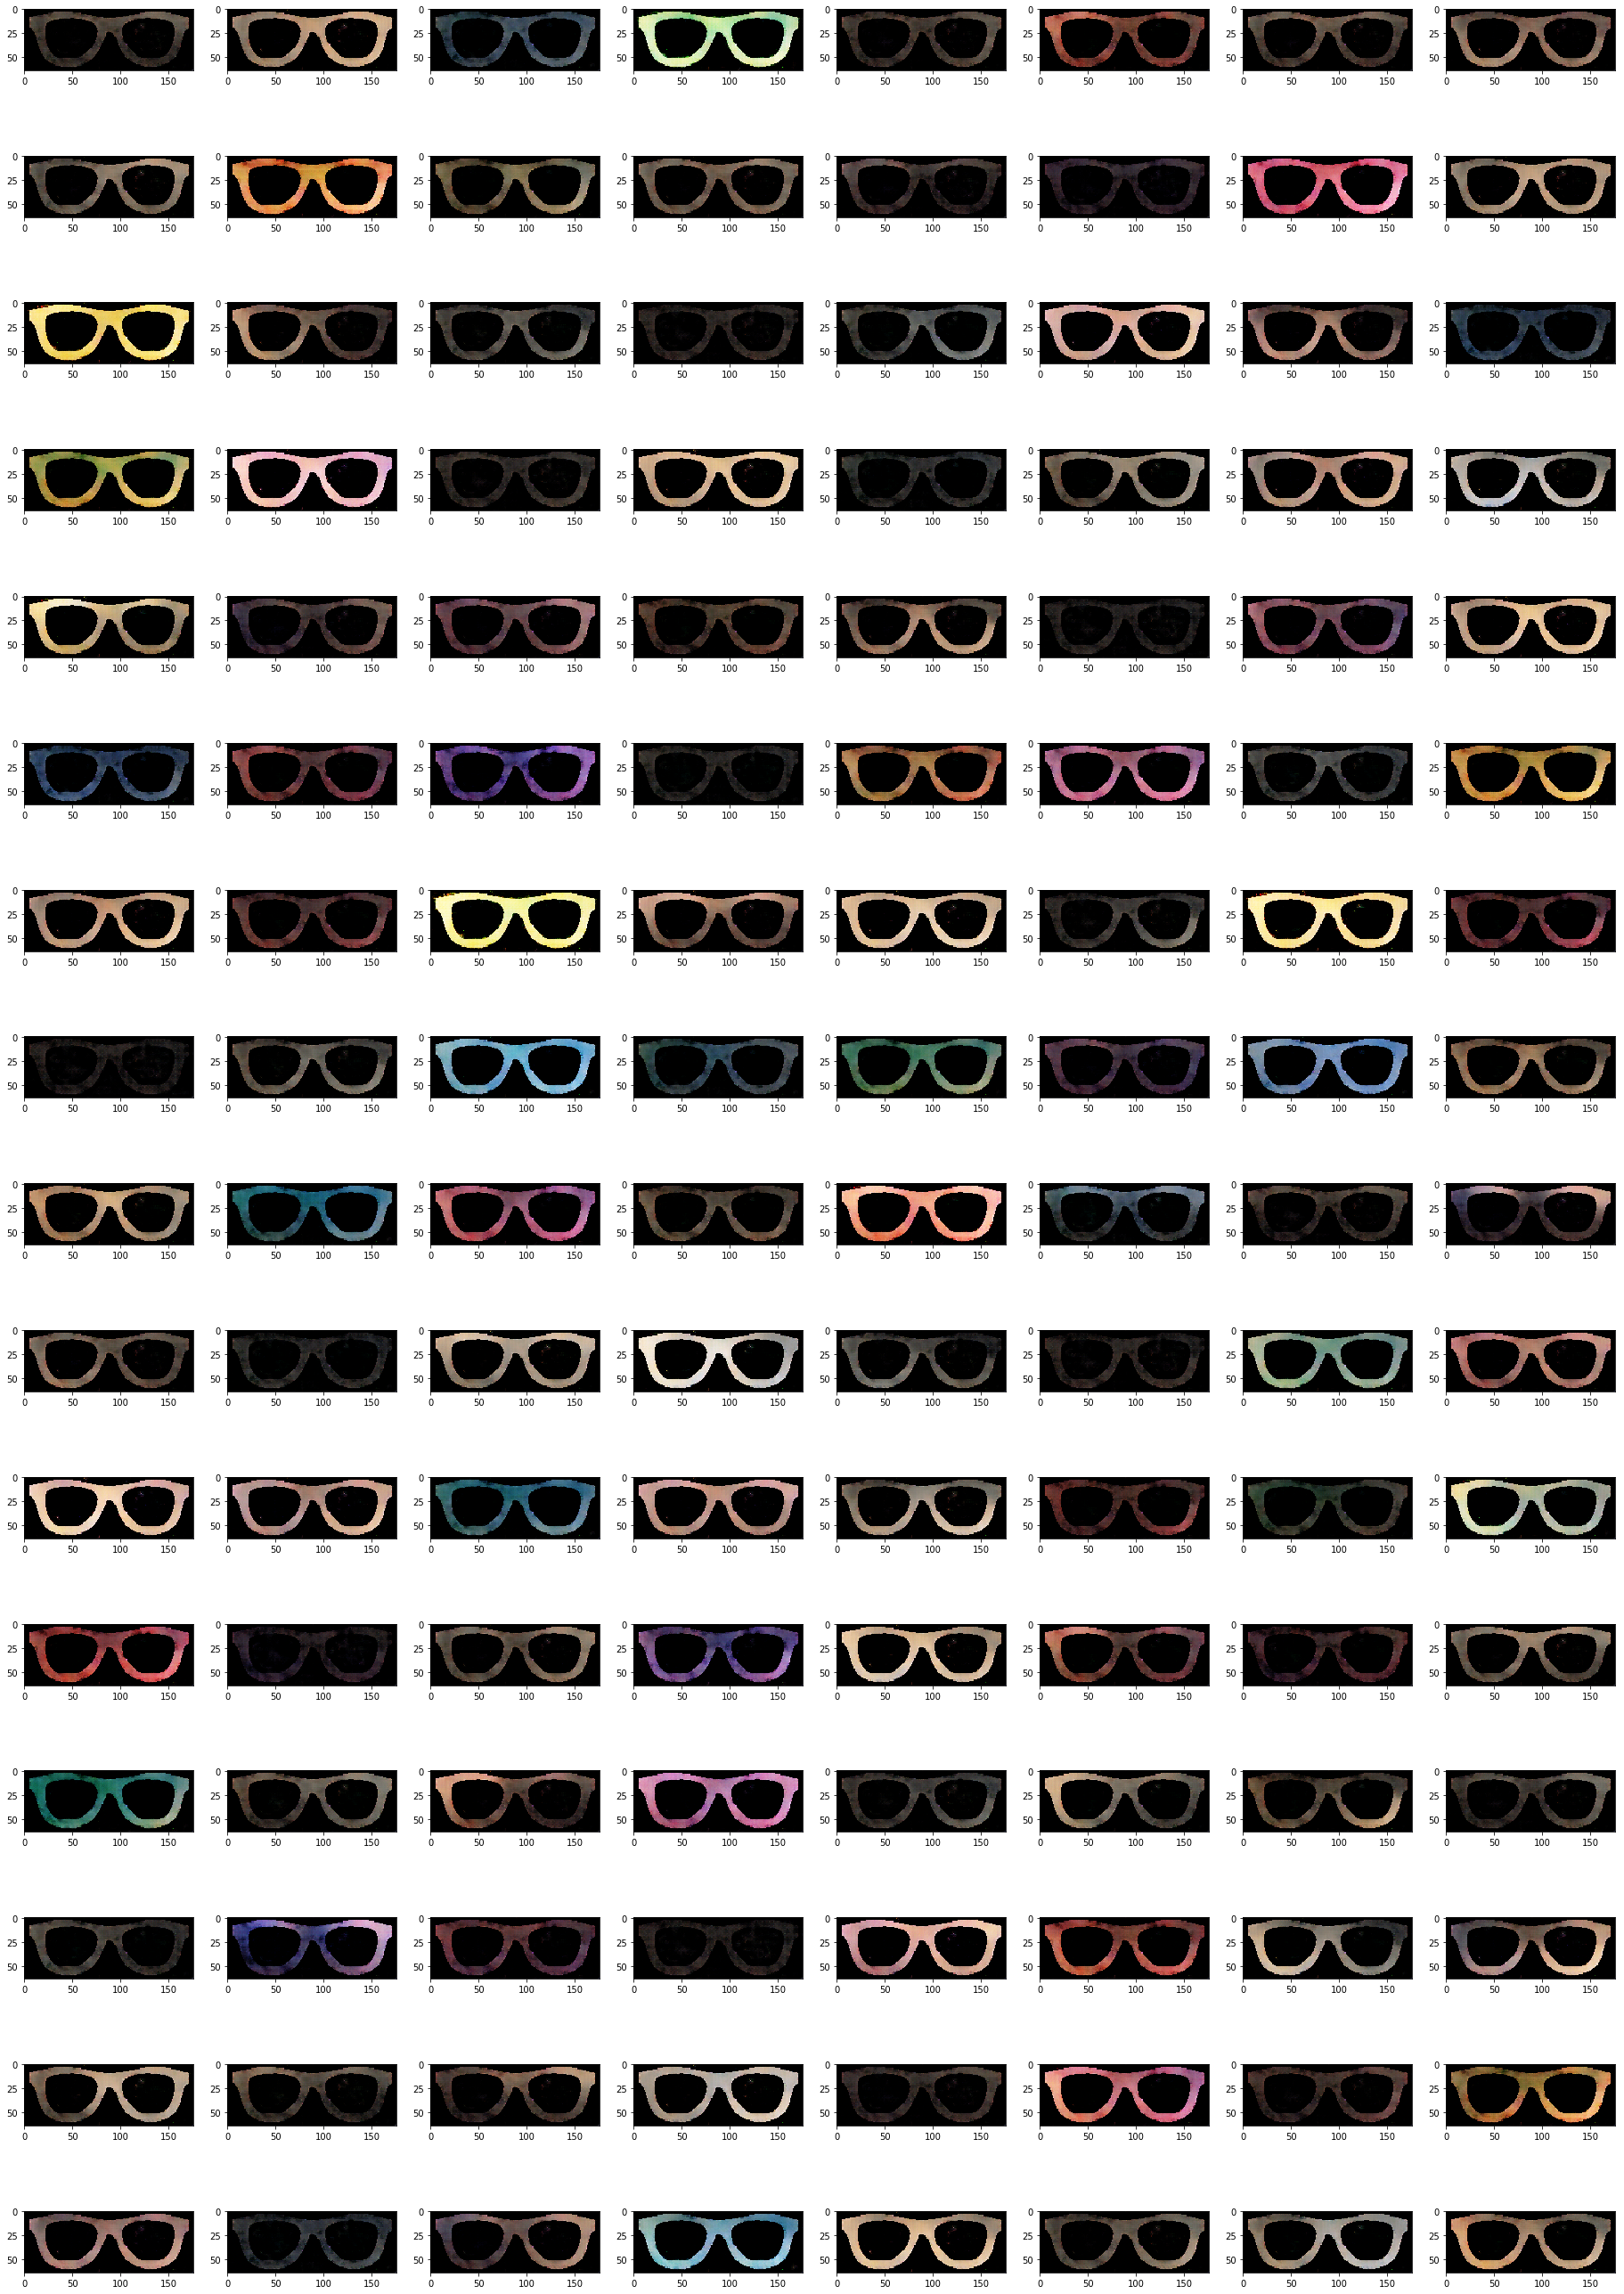

In [35]:
plt.figure(figsize=[32, 48])
sample_images(16, 8, net)

## Training

In [86]:
#optimizers
disc_opt = torch.optim.SGD(discriminator.parameters(), lr=2e-4)
gen_opt = torch.optim.Adam(generator.parameters(), lr=2e-4)

0 255


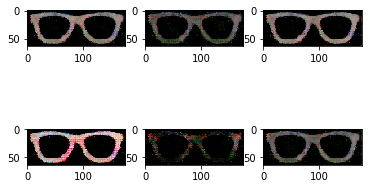

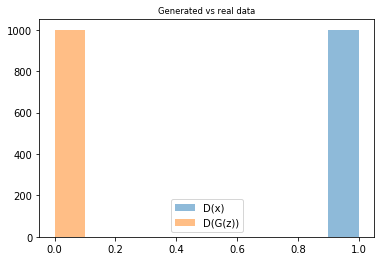

d loss 0.033403851091861725
d loss 0.0643414855003357
d loss 0.04104571416974068
d loss 0.03663647919893265
d loss 0.02443591319024563
g loss -0.005247035063803196
d loss 0.023161906749010086
d loss 0.09028173238039017
d loss 0.045597806572914124
d loss 0.030929673463106155
d loss 0.018634947016835213
g loss -0.006974685005843639
d loss 0.028231099247932434
d loss 0.022415628656744957
d loss 0.025515876710414886
d loss 0.02397220768034458
d loss 0.019941914826631546
g loss -0.003141419030725956
d loss 0.031374141573905945
d loss 0.022290537133812904
d loss 0.0202223751693964
d loss 0.018541980534791946
d loss 0.022516492754220963
g loss -0.004494462162256241
d loss 0.05494876205921173
d loss 0.03273029252886772
d loss 0.06639791280031204
d loss 0.03687189519405365
d loss 0.06684659421443939
g loss -0.01087096892297268
d loss 0.050862960517406464
d loss 0.043221719563007355
d loss 0.04050368070602417
d loss 0.039417728781700134
d loss 0.025870559737086296
g loss -0.006691961083561182
d 

KeyboardInterrupt: 

In [88]:
from IPython import display
from tqdm import tnrange
batch_size = 100

for epoch in tnrange(50000):
    
    # Train discriminator
    for i in range(5):
        real_data = sample_data_batch(batch_size)
        fake_data = generator(sample_noise_batch(batch_size))
        loss = discriminator_loss(real_data, fake_data)
        print('d loss', loss.item())
        disc_opt.zero_grad()
        loss.backward()
        disc_opt.step()
        
    # Train generator
    for i in range(1):
        noise = sample_noise_batch(batch_size)
        loss = generator_loss(noise)
        print('g loss', loss.item())
        gen_opt.zero_grad()
        loss.backward()
        gen_opt.step()

    if epoch %100==0:
        display.clear_output(wait=True)
        sample_images(2,3,True)
        sample_probas(1000)
        

0 255


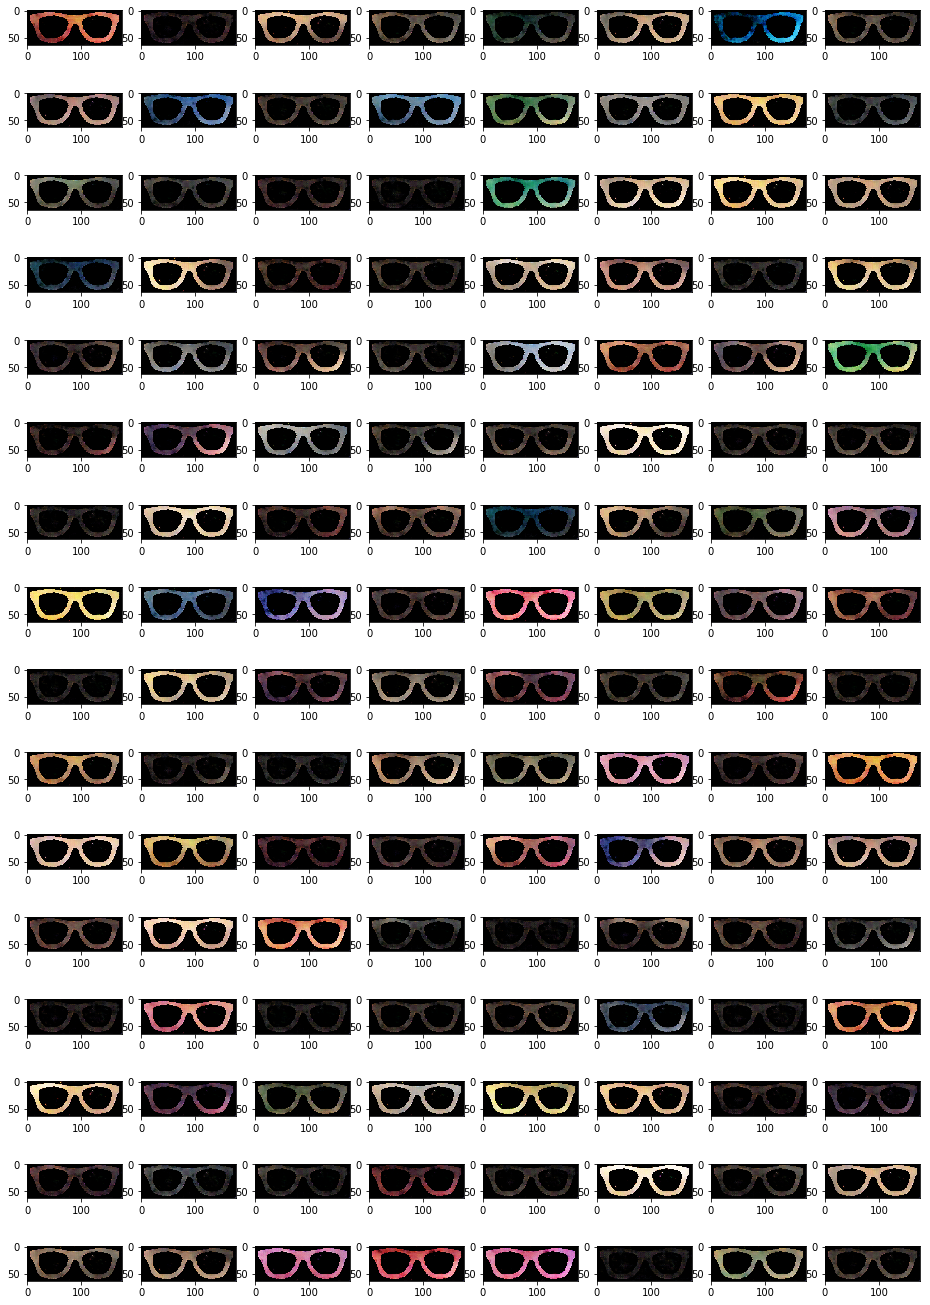

In [83]:
plt.figure(figsize=[16, 24])
sample_images(16, 8)

# Note: a no-nonsense neural network should be able to produce reasonably good images after 15k iterations
# By "reasonably good" we mean "resembling a car crash victim" or better

In [84]:
torch.save(generator.state_dict(), 'generator_good.pth')
torch.save(discriminator.state_dict(), 'discriminator_good.pth')

In [85]:
ls

agn_models.py             discriminator2.pth      generator2.pth
agns_advanced.ipynb       discriminator_good.pth  generator_good.pth
agns-real-eyeglasses.zip  eyeglasses/             __MACOSX/
discriminator1.pth        generator1.pth          Untitled.ipynb
